Using AdsorbDiff to enumerate adsorbates on alloy catalyst surfaces
======================================================

This case study was originally showcased [here](https://open-catalyst.metademolab.com/case-studies/nrr) with AdsorbML, we adapt it to show the same study with AdsorbDiff.

In this example, we constructed slab models of adsorbates on desired sites. Here we leverage code to automate this process. The goal in this section is to generate candidate structures, compute energetics, and then filter out the most relevant ones.

In [1]:
from adsorbdiff import AdsorbDiffCalculator
import ase.io
from ase.optimize import BFGS
import sys
from scipy.stats import linregress
import pickle
import matplotlib.pyplot as plt
import time

from adsorbdiff.placement import (
    Adsorbate,
    AdsorbateSlabConfig,
    Bulk,
    Slab,
    DetectTrajAnomaly,
)
import os
from glob import glob
import pandas as pd
from pathlib import Path

# Introduction

We will reproduce Fig 6b from the following paper: Zhou, Jing, et al. "Enhanced Catalytic Activity of Bimetallic Ordered Catalysts for Nitrogen Reduction Reaction by Perturbation of Scaling Relations." ACS Catalysis 134 (2023): 2190-2201 (https://doi.org/10.1021/acscatal.2c05877).

The gist of this figure is a correlation between H* and NNH* adsorbates across many different alloy surfaces. Then, they identify a dividing line between these that separates surfaces known for HER and those known for NRR.

To do this, we will enumerate adsorbate-slab configurations and run ML relaxations on them to find the lowest energy configuration. We will assess parity between the model predicted values and those reported in the paper. Finally we will make the figure and assess separability of the NRR favored and HER favored domains.

# Run all the systems

In principle you can run all the systems now. It takes about an hour though, and we leave that for a later exercise if you want. For now we will run the first two, and for later analysis we provide a results file of all the runs. Let's read in our reference file and take a look at what is in it.

Download checkpoints and set paths.

In [ ]:
curr_path = os.getcwd()
main_path = "/".join(curr_path.split("/")[:-2])

db = main_path + "/adsorbdiff/placement/pkls/adsorbates.pkl"

!wget -q https://zenodo.org/records/11152248/files/PT_zeroshot_painn.pt 
!wget -q https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/gemnet_oc_base_s2ef_all_md.pt 

diff_ckpt_path = "PT_zeroshot_painn.pt"
relax_ckpt_path = "gemnet_oc_base_s2ef_all_md.pt"

Optimizing through AdsorbDiff

In [2]:
adsorbate_smiles_nnh = "*N*NH"
adsorbate_smiles_h = "*H"

with open("NRR_example_bulks.pkl", "rb") as f:
    bulks = pickle.load(f)
    

bulk_ids = [row['src_id'] for row in bulks]

import time
from tqdm import tqdm

tinit = time.time()

calc_diff = AdsorbDiffCalculator(checkpoint_path=diff_ckpt_path, cpu=False)  
calc_opt = AdsorbDiffCalculator(checkpoint_path=relax_ckpt_path, cpu=False)

adsorbate_smiles_nnh = "*N*NH"
adsorbate_smiles_h = "*H"
adsorbate_H = Adsorbate(adsorbate_smiles_from_db = adsorbate_smiles_h, adsorbate_db_path=db)
adsorbate_NNH = Adsorbate(adsorbate_smiles_from_db = adsorbate_smiles_nnh, adsorbate_db_path=db)

for bulk_src_id in tqdm(bulk_ids): 
    # Enumerate slabs and establish adsorbates
    bulk = Bulk(bulk_src_id_from_db=bulk_src_id, bulk_db_path="NRR_example_bulks.pkl")
    slab = Slab.from_bulk_get_specific_millers(bulk= bulk, specific_millers=(1, 1, 1))

    # Perform heuristic placements
    random_adslabs_H = AdsorbateSlabConfig(slab[0], adsorbate_H, mode="heuristic", num_sites=1).atoms_list[0]
    random_adslabs_NNH = AdsorbateSlabConfig(slab[0], adsorbate_NNH, mode="heuristic", num_sites=1).atoms_list[0]


    os.makedirs(f"data/{bulk_src_id}_H", exist_ok=True)
    os.makedirs(f"data/{bulk_src_id}_NNH", exist_ok=True)

    diffused_adslab_H = calc_diff.run_diffusion(random_adslabs_H, trajectory=f"data/{bulk_src_id}_H/diff")
    diffused_adsorption_site = diffused_adslab_H.get_positions()[diffused_adslab_H.get_tags() == 2]
    diffused_adslab_H = AdsorbateSlabConfig(slab[0], adsorbate_H, sites=diffused_adsorption_site).atoms_list[0]
    
    diffused_adslab_H.calc = calc_opt
    opt = BFGS(diffused_adslab_H, trajectory=f"data/{bulk_src_id}_H/opt.traj", logfile=f"data/{bulk_src_id}_H/log.log")
    opt.run(fmax=0.05, steps=20)
    
    diffused_adslab_NNH = calc_diff.run_diffusion(random_adslabs_NNH, trajectory=f"data/{bulk_src_id}_NNH/diff")
    diffused_adsorption_site = diffused_adslab_NNH.get_positions()[diffused_adslab_NNH.get_tags() == 2]
    diffused_adslab_NNH = AdsorbateSlabConfig(slab[0], adsorbate_NNH, sites=diffused_adsorption_site, interstitial_gap=0.2).atoms_list[0]
    
    diffused_adslab_NNH.calc = calc_opt
    opt = BFGS(diffused_adslab_NNH, trajectory=f"data/{bulk_src_id}_NNH/opt.traj", logfile=f"data/{bulk_src_id}_H/log.log")
    opt.run(fmax=0.05, steps=50)
    
print(f'Elapsed time: {time.time() - tinit:1.1f} seconds')

100%|██████████| 19/19 [06:33<00:00, 20.72s/it]

Elapsed time: 795.4 seconds


# Parse the trajectories and post-process

As a post-processing step we check to see if:

1. the adsorbate desorbed
2. the adsorbate disassociated
3. the adsorbate intercalated
4. the surface has changed

We check these because they affect our referencing scheme and may result in energies that don't mean what we think, e.g. they aren't just adsorption, but include contributions from other things like desorption, dissociation or reconstruction. For (4), the relaxed surface should really be supplied as well. It will be necessary when correcting the SP / RX energies later. Since we don't have it here, we will ommit supplying it, and the detector will instead compare the initial and final slab from the adsorbate-slab relaxation trajectory. If a relaxed slab is provided, the detector will compare it and the slab after the adsorbate-slab relaxation. The latter is more correct!

In this loop we find the most stable (most negative) adsorption energy for each adsorbate on each surface and save them in a DataFrame.

In [3]:
# Iterate over trajs to extract results
min_E = [] 
total_anomalies = 0
for file_outer in glob("data/*"):
    ads = file_outer.split("_")[1]
    bulk = file_outer.split("/")[1].split("_")[0]
    results = []
    
    traj = ase.io.read(f"{file_outer}/opt.traj", ":")
    
    # Check to see if the trajectory is anomolous
    detector = DetectTrajAnomaly(traj[0], traj[-1], traj[0].get_tags())
    anom = (
        detector.is_adsorbate_dissociated()
        or detector.is_adsorbate_desorbed()
        or detector.has_surface_changed()
        or detector.is_adsorbate_intercalated()
    )
    rx_energy = traj[-1].get_potential_energy()
    results.append({"relaxed_atoms": traj[-1],
                    "relaxed_energy_ml": rx_energy, "anomolous": anom})
    df_init = pd.DataFrame(results)
    df = df_init[~df_init.anomolous].copy().reset_index()
    try:
        min_e = df.relaxed_energy_ml.tolist()[0]
        min_E.append({"adsorbate":ads, "bulk_id":bulk, "min_E_ml": min_e})
    except: 
        print(f"{file_outer} optimization lead to anomaly")
        total_anomalies += 1

df = pd.DataFrame(min_E)
df_h = df[df.adsorbate == "H"]
df_nnh = df[df.adsorbate == "NNH"]
df_flat = df_h.merge(df_nnh, on = "bulk_id")

data/oqmd-345911_NNH optimization lead to anomaly
data/oqmd-349496_NNH optimization lead to anomaly
data/oqmd-347528_NNH optimization lead to anomaly
data/oqmd-343039_NNH optimization lead to anomaly


data/oqmd-348366_NNH optimization lead to anomaly
data/oqmd-349813_NNH optimization lead to anomaly
data/oqmd-345352_NNH optimization lead to anomaly
data/oqmd-346653_NNH optimization lead to anomaly
data/oqmd-348629_NNH optimization lead to anomaly


For cases where there are anomalies, the optimization can be run with another adsorption site as demonstrated in AdsorbML. 

Note that in this work we get competitive performance with just a single ML relaxation.

In [4]:
df_flat

,adsorbate_x,bulk_id,min_E_ml_x,adsorbate_y,min_E_ml_y
0,H,oqmd-349719,-0.288163,NNH,1.585428
1,H,mp-2677,-0.595217,NNH,0.943365
2,H,mp-1186014,-0.786074,NNH,-0.948138
3,H,oqmd-344251,-0.587520,NNH,-1.968038
4,H,oqmd-343394,-1.019898,NNH,-1.197420
5,H,oqmd-346818,-0.302501,NNH,0.257134
6,H,oqmd-343006,0.436880,NNH,-0.804096
7,H,oqmd-344635,-0.558202,NNH,-0.587033
8,H,oqmd-343615,-0.554416,NNH,0.456835
9,H,oqmd-344237,-0.040890,NNH,-0.506428


# Make parity plots for values obtained by ML v. reported in the paper

In [5]:
# Add literature data to the dataframe
with open("literature_data.pkl", "rb") as f:
    literature_data = pickle.load(f)
df_all = df_flat.merge(pd.DataFrame(literature_data), on = "bulk_id")

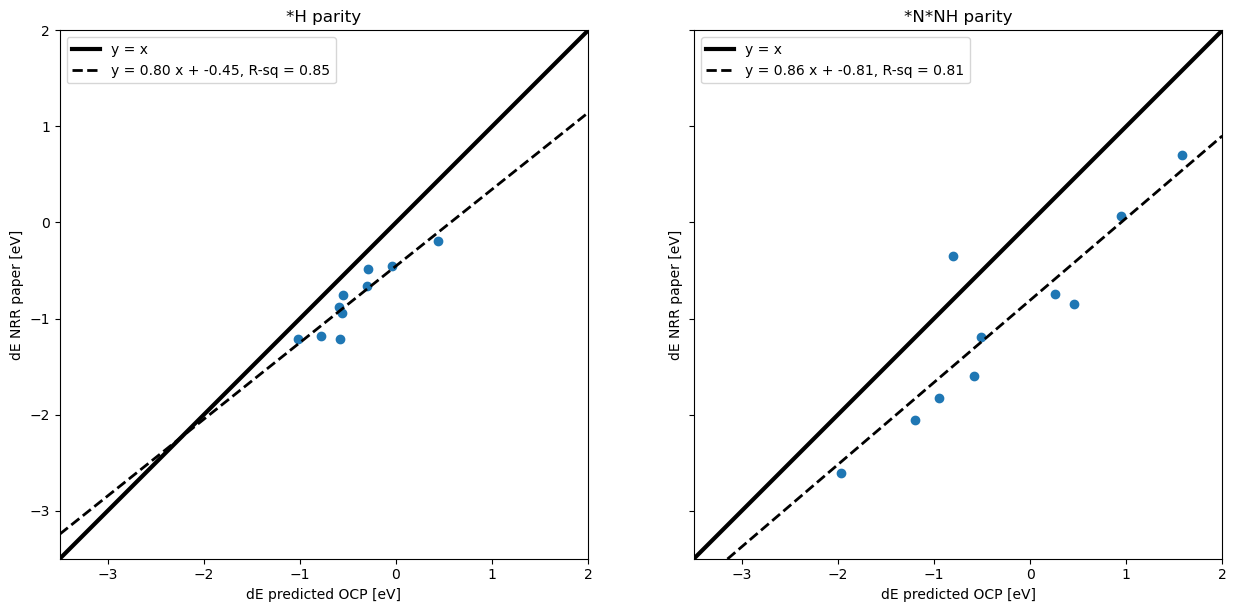

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(15)
x = df_all.min_E_ml_x.tolist()
y = df_all.E_lit_H.tolist()
ax1.set_title("*H parity")
ax1.plot([-3.5, 2], [-3.5, 2], "k-", linewidth=3)
slope, intercept, r, p, se = linregress(x, y)
ax1.plot(
    [-3.5, 2],
    [
        -3.5 * slope + intercept,
        2 * slope + intercept,
    ],
    "k--",
    linewidth=2,
)

ax1.legend(
    [
        "y = x",
        f"y = {slope:1.2f} x + {intercept:1.2f}, R-sq = {r**2:1.2f}",
    ],
    loc="upper left",
)
ax1.scatter(x, y)
ax1.axis("square")
ax1.set_xlim([-3.5, 2])
ax1.set_ylim([-3.5, 2])
ax1.set_xlabel("dE predicted OCP [eV]")
ax1.set_ylabel("dE NRR paper [eV]");


x = df_all.min_E_ml_y.tolist()
y = df_all.E_lit_NNH.tolist()
ax2.set_title("*N*NH parity")
ax2.plot([-3.5, 2], [-3.5, 2], "k-", linewidth=3)
slope, intercept, r, p, se = linregress(x, y)
ax2.plot(
    [-3.5, 2],
    [
        -3.5 * slope + intercept,
        2 * slope + intercept,
    ],
    "k--",
    linewidth=2,
)

ax2.legend(
    [
        "y = x",
        f"y = {slope:1.2f} x + {intercept:1.2f}, R-sq = {r**2:1.2f}",
    ],
    loc="upper left",
)
ax2.scatter(x, y)
ax2.axis("square")
ax2.set_xlim([-3.5, 2])
ax2.set_ylim([-3.5, 2])
ax2.set_xlabel("dE predicted OCP [eV]")
ax2.set_ylabel("dE NRR paper [eV]");
f.set_figwidth(15)
f.set_figheight(7)

# Make figure 6b and compare to literature results

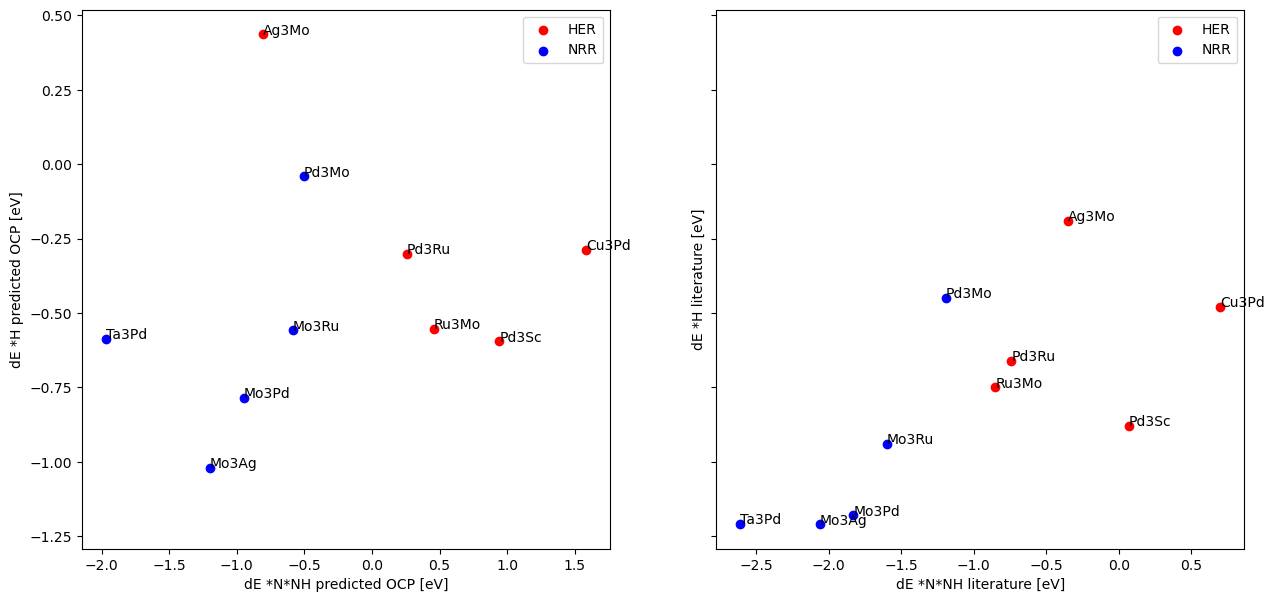

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
x = df_all[df_all.reaction == "HER"].min_E_ml_y.tolist()
y = df_all[df_all.reaction == "HER"].min_E_ml_x.tolist()
comp = df_all[df_all.reaction == "HER"].composition.tolist()

ax1.scatter(x, y,c= "r", label = "HER")
for i, txt in enumerate(comp):
    ax1.annotate(txt, (x[i], y[i]))

x = df_all[df_all.reaction == "NRR"].min_E_ml_y.tolist()
y = df_all[df_all.reaction == "NRR"].min_E_ml_x.tolist()
comp = df_all[df_all.reaction == "NRR"].composition.tolist()
ax1.scatter(x, y,c= "b", label = "NRR")
for i, txt in enumerate(comp):
    ax1.annotate(txt, (x[i], y[i]))


ax1.legend()
ax1.set_xlabel("dE *N*NH predicted OCP [eV]")
ax1.set_ylabel("dE *H predicted OCP [eV]")


x = df_all[df_all.reaction == "HER"].E_lit_NNH.tolist()
y = df_all[df_all.reaction == "HER"].E_lit_H.tolist()
comp = df_all[df_all.reaction == "HER"].composition.tolist()

ax2.scatter(x, y,c= "r", label = "HER")
for i, txt in enumerate(comp):
    ax2.annotate(txt, (x[i], y[i]))

x = df_all[df_all.reaction == "NRR"].E_lit_NNH.tolist()
y = df_all[df_all.reaction == "NRR"].E_lit_H.tolist()
comp = df_all[df_all.reaction == "NRR"].composition.tolist()
ax2.scatter(x, y,c= "b", label = "NRR")
for i, txt in enumerate(comp):
    ax2.annotate(txt, (x[i], y[i]))

ax2.legend()
ax2.set_xlabel("dE *N*NH literature [eV]")
ax2.set_ylabel("dE *H literature [eV]")
f.set_figwidth(15)
f.set_figheight(7)